Mean squared error (CuPy): 3.998890390186939e-09


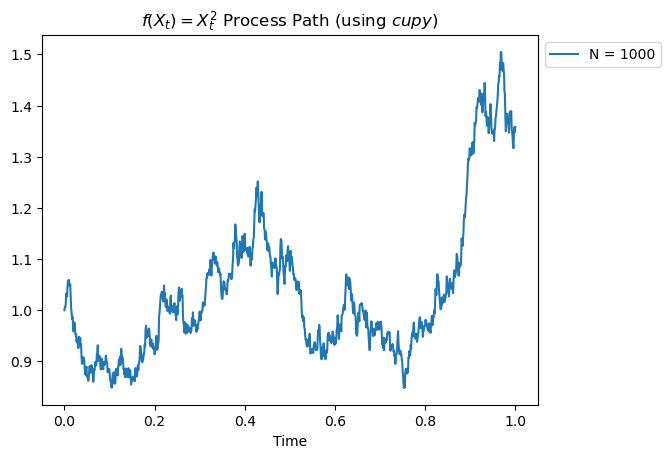

In [27]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

def weiner(T, N, n_paths, seed=None):
    if seed is not None:
        np.random.seed(seed) 
    dt = T / N
    increments = np.random.normal(0, np.sqrt(dt), (n_paths, N))
    path = np.cumsum(increments, axis=1)
    time = np.linspace(0, T, N + 1)
    return cp.array(time, dtype=cp.float64), cp.concatenate((cp.zeros((n_paths, 1), dtype=cp.float64), cp.array(path, dtype=cp.float64)), axis=1)

def f(x):
    return x**2

def fp(x):
    return 2*x

def fpp(x):
    return 2

def ft(x):
    return 0

ito_kernel_code = '''
extern "C" __global__
void ito_kernel(const double* X, double mu, double sigma, double dt,
                const double* dW, double* num_df, double* ito_df,
                int n_paths, int N) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int path_idx = idx / N;
    int t_idx = idx % N;
   
    if (path_idx < n_paths && t_idx < N) {
        int flat_idx = path_idx * N + t_idx;
        double x_t = X[path_idx * (N + 1) + t_idx];
        double x_tp1 = X[path_idx * (N + 1) + t_idx + 1];
       
        num_df[flat_idx] = (x_tp1 * x_tp1) - (x_t * x_t);
       
        double fp_x = 2 * x_t;
        double fpp_x = 2;
        double ft_x = 0;
        double ito_val = (ft_x + mu * x_t * fp_x + (sigma * sigma * x_t * x_t / 2) * fpp_x) * dt +
                         sigma * x_t * fp_x * dW[flat_idx];
        ito_df[flat_idx] = ito_val;
    }
}
'''
ito_kernel = cp.RawKernel(ito_kernel_code, 'ito_kernel')

def simX(T, N, mu, sigma, X0, n_paths, seed=None):
    dt = T / N
    time, W = weiner(T, N, n_paths, seed)
    X = cp.zeros((n_paths, N + 1), dtype=cp.float64)
    X[:, 0] = X0
    for i in range(N):
        X[:, i + 1] = X[:, i] + mu * X[:, i] * dt + sigma * X[:, i] * (W[:, i + 1] - W[:, i])
    return time, X, W

def itoValidation(T, N, mu, sigma, X0, n_paths, seed=None):
    dt = T / N
    if seed is not None:
        np.random.seed(seed)
   
    time, X_all, W_all = simX(T, N, mu, sigma, X0, n_paths, seed)
    dW_all = W_all[:, 1:] - W_all[:, :-1]
   
    if cp.any(cp.isnan(X_all)) or cp.any(cp.isnan(dW_all)):
        raise ValueError("NaN detected in X_all or dW_all")
   
    num_df = cp.zeros(n_paths * N, dtype=cp.float64)
    ito_df = cp.zeros(n_paths * N, dtype=cp.float64)
   
    block_size = 256
    grid_size = (n_paths * N + block_size - 1) // block_size
    ito_kernel((grid_size,), (block_size,),
              (X_all.ravel(), mu, sigma, dt, dW_all.ravel(), num_df, ito_df, n_paths, N))
   
    if cp.any(cp.isnan(num_df)) or cp.any(cp.isnan(ito_df)):
        raise ValueError("NaN detected in num_df or ito_df")
   
    return num_df.get(), ito_df.get()

T = 1
N = 1000
mu = 0.05
sigma = 0.2
X0 = 1.0
n_paths = 100

num_df, ito_df = itoValidation(T, N, mu, sigma, X0, n_paths, seed=42)
mse = np.mean((num_df - ito_df)**2)
print(f'Mean squared error (CuPy): {mse}')

time, path, _ = simX(T, N, mu, sigma, X0, 1, 42)
plt.plot(time.get(), f(path[0]).get(), label=f'N = {N}')
plt.title("$f(X_t) = X_t^2$ Process Path (using $cupy$)")
plt.xlabel("Time")
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()